# Load Data

In [1]:
train_path = '/kaggle/input/train'
val_path = '/kaggle/input/validation'
test_path = '/kaggle/input/test'

In [2]:
meningioma_path = '/kaggle/input/train/Meningioma'
glioma_path = '/kaggle/input/train/Glioma'
pituitary_path = '/kaggle/input/train/Pituitary'

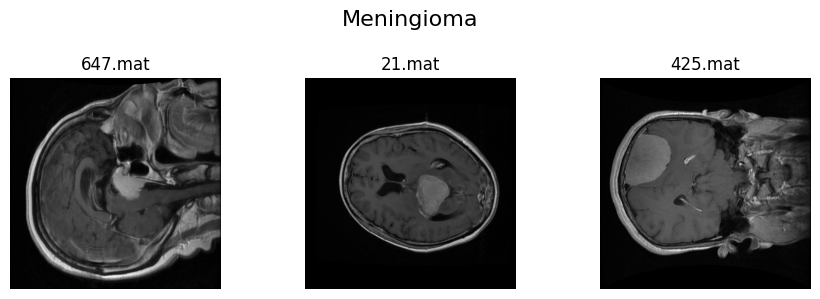

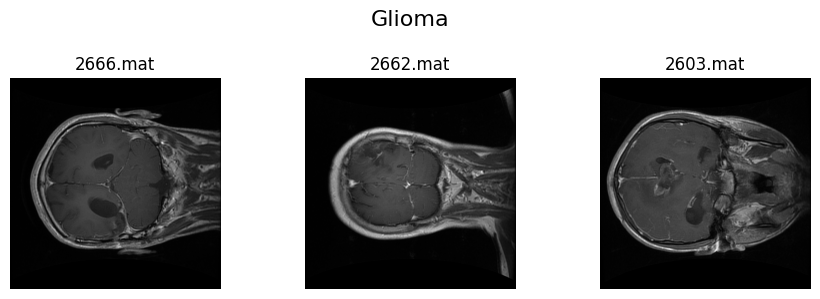

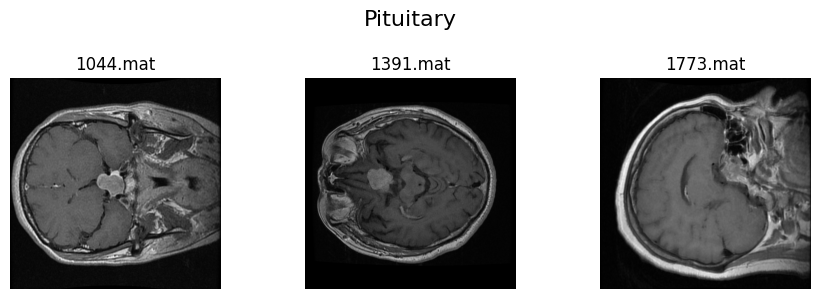

In [3]:
import os
import h5py
import matplotlib.pyplot as plt

# Organize the paths for looping
tumor_paths = {
    'Meningioma': meningioma_path,
    'Glioma': glioma_path,
    'Pituitary': pituitary_path
}

# Function to load and display three sample images from each folder
def display_sample_images(tumor_paths):
    for tumor_type, folder_path in tumor_paths.items():
        # Get all .mat files in the folder
        files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

        # Select up to 3 files
        files = files[10:13]

        # Create a figure for displaying images
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        fig.suptitle(f'{tumor_type}', fontsize=16)

        for ax, filename in zip(axes, files):
            file_path = os.path.join(folder_path, filename)
            with h5py.File(file_path, 'r') as file:
                cjdata = file['cjdata']
                image = cjdata['image'][:]

            # Display the image
            ax.imshow(image.squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(filename)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Execute the function
display_sample_images(tumor_paths)

In [4]:
import os
import h5py
import numpy as np

def load_data_from_folder(folder_path):
    data = []

    # Menelusuri semua file dalam folder (termasuk subfolder)
    for root, _, files in os.walk(folder_path):
        mat_files = [f for f in files if f.endswith('.mat')]

        for filename in mat_files:
            file_path = os.path.join(root, filename)
            try:
                with h5py.File(file_path, 'r') as file:
                    cjdata = file['cjdata']
                    image = np.array(cjdata['image'])
                    label = int(np.array(cjdata['label']))
                    tumor_mask = np.array(cjdata['tumorMask']) if 'tumorMask' in cjdata else None

                    # Menambahkan data ke dalam list
                    data.append({
                        'filename': filename,
                        'image': image,
                        'label': label,
                        'tumor_mask': tumor_mask,
                        'path': file_path
                    })
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    return data

In [5]:
# Memuat data dari folder train, validation, dan test
train_data = load_data_from_folder(train_path)
val_data = load_data_from_folder(val_path)
test_data = load_data_from_folder(test_path)

# Contoh informasi jumlah data yang dimuat
print(f"Train data: {len(train_data)} files")
print(f"Validation data: {len(val_data)} files")
print(f"Test data: {len(test_data)} files")

/tmp/ipykernel_35/965592414.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(np.array(cjdata['label']))


Train data: 1959 files
Validation data: 491 files
Test data: 614 files


In [6]:
meningioma_path = load_data_from_folder(meningioma_path)
glioma_path = load_data_from_folder(glioma_path)
pituitary_path = load_data_from_folder(pituitary_path)

# Contoh informasi jumlah data yang dimuat
print(f"Meningioma: {len(meningioma_path)} files")
print(f"Glioma: {len(glioma_path)} files")
print(f"Pituitary: {len(pituitary_path)} files")

/tmp/ipykernel_35/965592414.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(np.array(cjdata['label']))


Meningioma: 452 files
Glioma: 912 files
Pituitary: 595 files


# Augmentation

In [7]:
import random
import numpy as np
from scipy.ndimage import rotate
from skimage.util import random_noise

def augment_image(image, rotation_angles):
    # Pilih satu sudut rotasi secara random
    
    angle = random.choice(rotation_angles)
    
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    return rotated_image

In [8]:
def augment_class(class_data, rotation_angles=[45, 90, 180, 270, 315]):
    augmented_data = []

    for idx, sample in enumerate(class_data):
        image = sample['image']
        aug_img = augment_image(image, rotation_angles)

        augmented_data.append({
            'filename': f"aug_{idx}",
            'image': aug_img,
            'label': sample['label'],
            'tumor_mask': sample['tumor_mask']
        })

    return augmented_data

In [9]:
# Lakukan augmentasi satu kali untuk setiap gambar
augmented_meningioma = augment_class(meningioma_path)
augmented_pituitary = augment_class(pituitary_path)

# Informasi jumlah data augmentasi
print(f"Meningioma augmented count: {len(augmented_meningioma)} files")
print(f"Pituitary augmented count: {len(augmented_pituitary)} files")

Meningioma augmented count: 452 files
Pituitary augmented count: 595 files


In [10]:
combined_meningioma = meningioma_path + augmented_meningioma
combined_pituitary = pituitary_path + augmented_pituitary

# Informasi jumlah data setelah augmentasi
print(f"Meningioma augmented count: {len(combined_meningioma)} files")
print(f"Pituitary augmented count: {len(combined_pituitary)} files")

Meningioma augmented count: 904 files
Pituitary augmented count: 1190 files


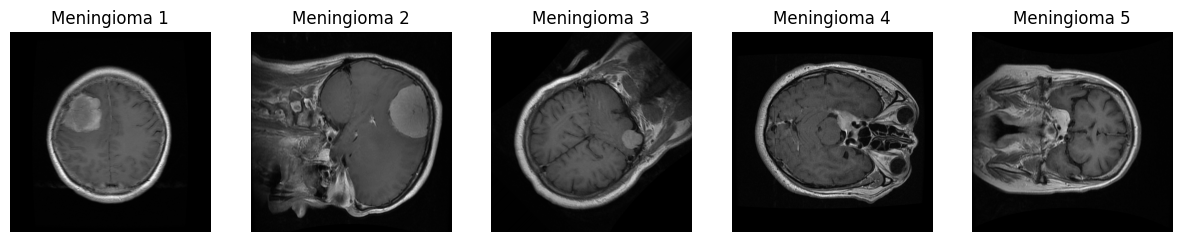

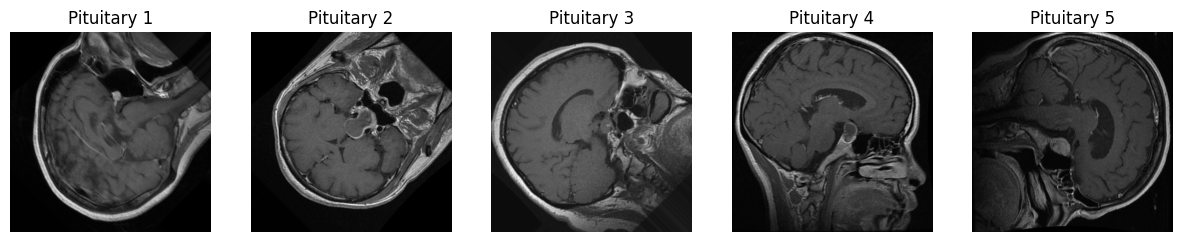

In [11]:
import matplotlib.pyplot as plt
import random

def show_augmented_samples(augmented_data, title_prefix, sample_count=5):
    # Ambil sampel acak
    samples = random.sample(augmented_data, sample_count)

    # Tampilkan gambar
    plt.figure(figsize=(15, 3))
    for i, sample in enumerate(samples):
        plt.subplot(1, sample_count, i + 1)
        plt.imshow(sample['image'], cmap='gray')
        plt.title(f"{title_prefix} {i+1}")
        plt.axis('off')
    plt.show()

# Tampilkan contoh hasil augmentasi
show_augmented_samples(augmented_meningioma, "Meningioma")
show_augmented_samples(augmented_pituitary, "Pituitary")

# Feature Fusion

In [12]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
import cv2
import numpy as np
from sklearn.preprocessing import normalize

2025-05-27 16:52:28.761126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748364748.957917      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748364749.010876      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
# Load 2 model tanpa top layers
def load_mobilenetv2_model():
    mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    mobilenetv2_out = GlobalAveragePooling2D()(mobilenetv2.output)
    return Model(inputs=mobilenetv2.input, outputs=mobilenetv2_out)

def load_resnet50_model():
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet50_out = GlobalAveragePooling2D()(resnet50.output)
    return Model(inputs=resnet50.input, outputs=resnet50_out)

# Convert grayscale images to RGB
def convert_to_rgb(img):
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    return img

In [14]:
# Extract features from a single image using both models
def extract_features(models, img):
    img = convert_to_rgb(img)
    img_resized = cv2.resize(img, (224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Extract features from both models
    features_list = []
    for model, preprocess_fn in models:
        preprocessed_img = preprocess_fn(img_array)
        features = model.predict(preprocessed_img)
        features_list.append(features)

    # Concatenate features
    fused_features = np.concatenate(features_list, axis=1)

    # Normalize L2
    normalized_features = normalize(fused_features, norm='l2')

    return normalized_features

In [17]:
# Apply feature extraction to dataset
def extract_features_from_data(data, models):
    features_list = []
    for sample in data:
        image = sample['image']
        features = extract_features(models, image)
        features_list.append(features)
    return np.array(features_list)

In [15]:
# Load models
mobilenetv2_model = load_mobilenetv2_model()
resnet50_model = load_resnet50_model()

# List of models and their respective preprocess functions
models = [(mobilenetv2_model, preprocess_mobilenet), (resnet50_model, preprocess_resnet)]

I0000 00:00:1748364841.870388      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Train Features Extraction

In [18]:
# Feature Fusion pada data train (augmented)
X_train = extract_features_from_data(combined_meningioma + combined_pituitary + glioma_path, models)
y_train = [sample['label'] for sample in combined_meningioma + combined_pituitary + glioma_path]

I0000 00:00:1748364873.664115      99 service.cc:148] XLA service 0x78069403b7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748364873.664803      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748364874.136958      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1748364876.534329      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

## Validation Features Extraction

In [19]:
# Feature Fusion pada data validation
X_val = extract_features_from_data(val_data, models)
y_val = [sample['label'] for sample in val_data]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

## Test Features Extraction

In [20]:
# Feature Fusion pada data test
X_test = extract_features_from_data(test_data, models)
y_test = [sample['label'] for sample in test_data]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

## Check Dimension

In [21]:
# Cek dimensi hasil ekstraksi fitur
print(f"Train feature dimension: {X_train.shape}")
print(f"Validation feature dimension: {X_val.shape}")
print(f"Test feature dimension: {X_test.shape}")

Train feature dimension: (3006, 1, 3328)
Validation feature dimension: (491, 1, 3328)
Test feature dimension: (614, 1, 3328)


In [22]:
# Pastikan fitur hasil ekstraksi memiliki bentuk 2D dan ubah menjadi array NumPy
X_train = np.array(X_train).reshape(X_train.shape[0], -1)
X_val = np.array(X_val).reshape(X_val.shape[0], -1)
X_test = np.array(X_test).reshape(X_test.shape[0], -1)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Konfirmasi dimensi
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3006, 3328), y_train shape: (3006,)
X_val shape: (491, 3328), y_val shape: (491,)
X_test shape: (614, 3328), y_test shape: (614,)


# Classification

In [23]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.ensemble import VotingClassifier, StackingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Grid Search

In [24]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Parameter Grid
param_grid_linear = {'C': [0.1, 1.0, 10]}
param_grid_poly = {'C': [0.1, 1.0, 10], 'degree': [2, 3, 4]}
param_grid_rbf = {'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1]}

# Fungsi Grid Search Manual
def grid_search_no_cv(model, param_grid, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = None
    best_score = 0
    best_train_time = None

    for params in ParameterGrid(param_grid):
        model.set_params(**params)

        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()
        train_time = end_train - start_train

        val_accuracy = model.score(X_val, y_val)
        print(f"Params: {params}, Val Accuracy: {val_accuracy:.4f}, Train Time: {train_time:.6f} sec")

        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = params
            best_train_time = train_time
            best_kernel = model.kernel

    # Setelah memilih hyperparameter terbaik, buat model baru dengan parameter tersebut
    best_model = SVC(kernel=best_kernel, probability=True, **best_params)
    return best_model, best_params, best_score, best_train_time

In [25]:
# Grid Search untuk Linear
print("Grid Search for Linear SVM")
best_svm_linear, best_params_linear, best_score_linear, train_time_linear = grid_search_no_cv(
    SVC(kernel='linear', probability=True), param_grid_linear, X_train, y_train, X_val, y_val
)
print(f"Best Linear Params: {best_params_linear}, Accuracy: {best_score_linear:.4f}, Train Time: {train_time_linear:.6f} sec\n")

# Grid Search untuk Polynomial
print("Grid Search for Polynomial SVM")
best_svm_poly, best_params_poly, best_score_poly, train_time_poly = grid_search_no_cv(
    SVC(kernel='poly', probability=True), param_grid_poly, X_train, y_train, X_val, y_val
)
print(f"Best Polynomial Params: {best_params_poly}, Accuracy: {best_score_poly:.4f}, Train Time: {train_time_poly:.6f} sec\n")

# Grid Search untuk RBF
print("Grid Search for RBF SVM")
best_svm_rbf, best_params_rbf, best_score_rbf, train_time_rbf = grid_search_no_cv(
    SVC(kernel='rbf', probability=True), param_grid_rbf, X_train, y_train, X_val, y_val
)
print(f"Best RBF Params: {best_params_rbf}, Accuracy: {best_score_rbf:.4f}, Train Time: {train_time_rbf:.6f} sec\n")

# Pilih model terbaik dari ketiga kernel berdasarkan validasi
best_accs = [best_score_linear, best_score_poly, best_score_rbf]
best_models = [best_svm_linear, best_svm_poly, best_svm_rbf]
best_params_list = [best_params_linear, best_params_poly, best_params_rbf]
kernels = ['linear', 'poly', 'rbf']

best_index = best_accs.index(max(best_accs))
final_kernel = kernels[best_index]
final_params = best_params_list[best_index]

print(f"Selected best model: Kernel={final_kernel}, Params={final_params}, Validation Accuracy={best_accs[best_index]:.4f}")

Grid Search for Linear SVM
Params: {'C': 0.1}, Val Accuracy: 0.8269, Train Time: 69.880840 sec
Params: {'C': 1.0}, Val Accuracy: 0.9002, Train Time: 35.800145 sec
Params: {'C': 10}, Val Accuracy: 0.9246, Train Time: 23.557815 sec
Best Linear Params: {'C': 10}, Accuracy: 0.9246, Train Time: 23.557815 sec

Grid Search for Polynomial SVM
Params: {'C': 0.1, 'degree': 2}, Val Accuracy: 0.8819, Train Time: 57.188114 sec
Params: {'C': 0.1, 'degree': 3}, Val Accuracy: 0.9002, Train Time: 50.753508 sec
Params: {'C': 0.1, 'degree': 4}, Val Accuracy: 0.9084, Train Time: 47.488086 sec
Params: {'C': 1.0, 'degree': 2}, Val Accuracy: 0.9206, Train Time: 30.183290 sec
Params: {'C': 1.0, 'degree': 3}, Val Accuracy: 0.9308, Train Time: 29.826047 sec
Params: {'C': 1.0, 'degree': 4}, Val Accuracy: 0.9389, Train Time: 32.537318 sec
Params: {'C': 10, 'degree': 2}, Val Accuracy: 0.9409, Train Time: 26.720173 sec
Params: {'C': 10, 'degree': 3}, Val Accuracy: 0.9409, Train Time: 28.361838 sec
Params: {'C': 10,

In [26]:
# Training ulang model terbaik pada keseluruhan data training (train + val)
X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

final_model = SVC(kernel=final_kernel, probability=True, **final_params)
final_model.fit(X_train_full, y_train_full)

SVC(C=10, gamma=1, probability=True)

## **SVM Classifier**

Test Time Total: 2.957270 sec
Test Time per Image: 0.004816 sec

Test Accuracy: 0.9609
Precision: 0.9619
Recall:    0.9609
F1-score:  0.9611


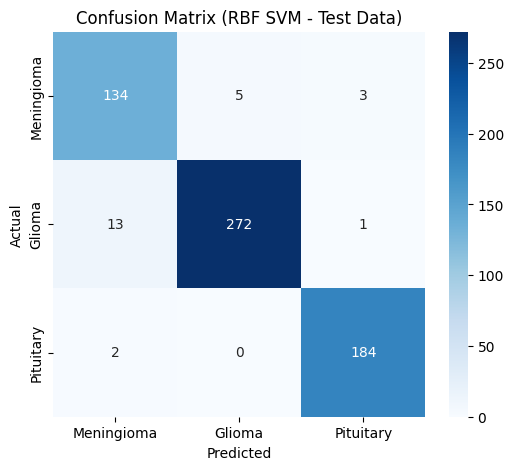

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

start_test = time.time()
y_pred = final_model.predict(X_test)
end_test = time.time()

test_time_total = end_test - start_test
test_time_per_image = test_time_total / len(X_test)

print(f"Test Time Total: {test_time_total:.6f} sec")
print(f"Test Time per Image: {test_time_per_image:.6f} sec")

test_accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Confusion Matrix Test
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Meningioma', 'Glioma', 'Pituitary'],
            yticklabels=['Meningioma', 'Glioma', 'Pituitary'])
plt.title(f'Confusion Matrix ({final_kernel.upper()} SVM - Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Voting**

In [28]:
best_svm_linear.fit(X_train_full, y_train_full)
best_svm_poly.fit(X_train_full, y_train_full)
best_svm_rbf.fit(X_train_full, y_train_full)

# Buat Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svm_linear', best_svm_linear),
    ('svm_poly', best_svm_poly),
    ('svm_rbf', best_svm_rbf)
], voting='hard')

# Training VotingClassifier
start_train_voting = time.time()
voting_clf.fit(X_train_full, y_train_full)
end_train_voting = time.time()

# Hitung waktu pelatihan
train_time_voting_total = end_train_voting - start_train_voting
train_time_voting_per_image = train_time_voting_total / len(X_train_full)

print(f"Train Time (Voting): {train_time_voting_total:.6f} seconds")
print(f"Train Time per Image (Voting): {train_time_voting_per_image:.6f} seconds")

Train Time (Voting): 111.275641 seconds
Train Time per Image (Voting): 0.031820 seconds


### Confusion Matrix Training


Training Accuracy: 0.9994
Training Precision: 0.9994
Training Recall: 0.9994
Training F1 Score: 0.9994


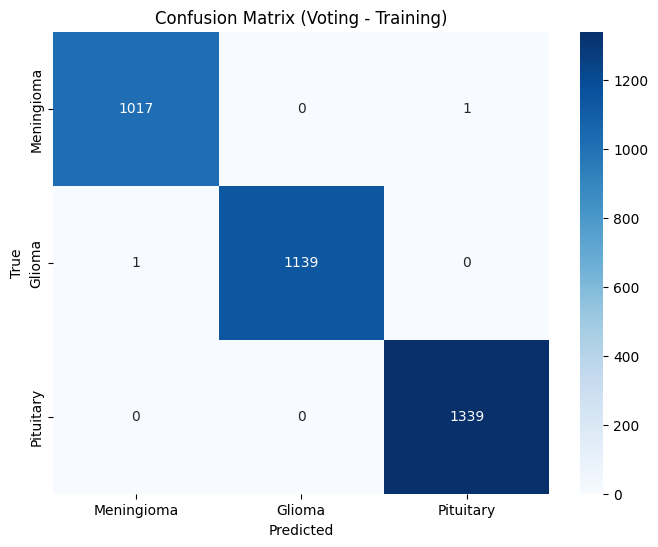

In [29]:
# Evaluasi pada data training (gabungan train+val)
y_train_pred = voting_clf.predict(X_train_full)

train_accuracy = accuracy_score(y_train_full, y_train_pred)
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(y_train_full, y_train_pred, average='weighted')

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1_score:.4f}")

# Confusion Matrix untuk training
conf_matrix_train = confusion_matrix(y_train_full, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Meningioma', 'Glioma', 'Pituitary'],
            yticklabels=['Meningioma', 'Glioma', 'Pituitary'])
plt.title('Confusion Matrix (Voting - Training)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Cofusion Matrix - Testing

Test Time (Voting): 5.061834 seconds
Test Time per Image (Voting): 0.008244 seconds
Test Accuracy: 0.9544
Test Precision: 0.9554
Test Recall: 0.9544
Test F1 Score: 0.9547


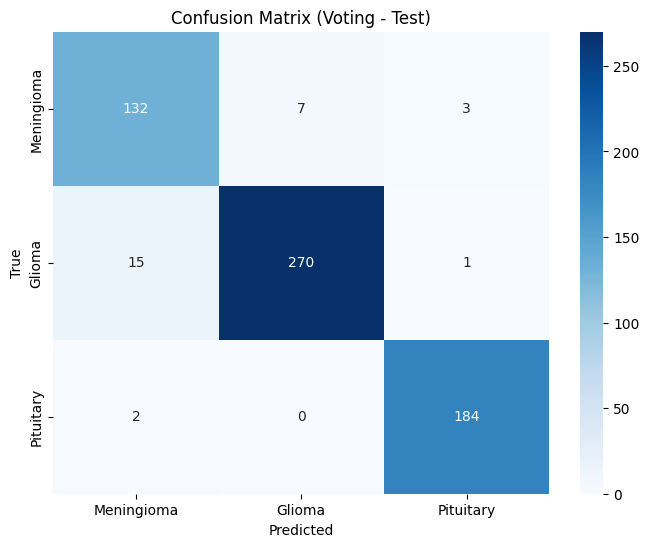

     Linear  Polynomial  RBF  Final_Vote
0         3           3    3           3
1         3           3    3           3
2         3           3    3           3
3         3           3    3           3
4         3           3    3           3
..      ...         ...  ...         ...
195       3           1    1           1
196       1           1    1           1
197       1           1    1           1
198       1           1    1           1
199       2           1    1           1

[200 rows x 4 columns]

Distribusi Kombinasi Voting:
    Linear  Polynomial  RBF  Count
0        1           1    1    136
1        1           1    2      2
2        1           2    1      2
3        1           2    2      5
4        1           3    3      2
5        2           1    1      5
6        2           1    2      1
7        2           2    1      2
8        2           2    2    269
9        3           1    1      4
10       3           3    3    186


In [30]:
import pandas as pd

# Evaluasi pada data uji
start_test_voting = time.time()
y_test_pred = voting_clf.predict(X_test)
end_test_voting = time.time()

# Waktu prediksi
test_time_voting_total = end_test_voting - start_test_voting
test_time_voting_per_image = test_time_voting_total / len(X_test)

print(f"Test Time (Voting): {test_time_voting_total:.6f} seconds")
print(f"Test Time per Image (Voting): {test_time_voting_per_image:.6f} seconds")

# Evaluasi performa
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Meningioma', 'Glioma', 'Pituitary'],
            yticklabels=['Meningioma', 'Glioma', 'Pituitary'])
plt.title('Confusion Matrix (Voting - Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Analisis hasil voting dari masing-masing model
y_pred_linear = best_svm_linear.predict(X_test)
y_pred_poly = best_svm_poly.predict(X_test)
y_pred_rbf = best_svm_rbf.predict(X_test)

# Gabungkan semua prediksi ke DataFrame
y_pred_all = np.vstack((y_pred_linear, y_pred_poly, y_pred_rbf, y_test_pred)).T
df_results = pd.DataFrame(y_pred_all, columns=['Linear', 'Polynomial', 'RBF', 'Final_Vote'])

print(df_results.head(200))  # Contoh hasil
vote_counts = df_results.groupby(['Linear', 'Polynomial', 'RBF']).size().reset_index(name='Count')
print("\nDistribusi Kombinasi Voting:")
print(vote_counts)

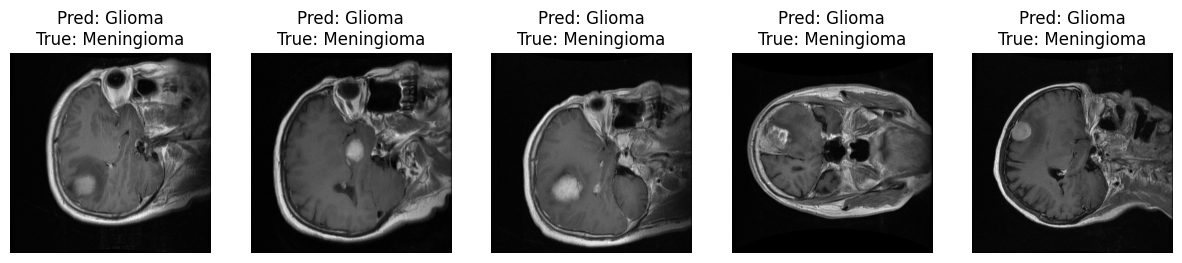

In [31]:
# Konversi y_test dan y_test_pred ke NumPy array jika belum
y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)

# Label numerik untuk masing-masing kelas
label_meningioma = 1  # Sesuai dengan dataset Anda
label_glioma = 2

# Ambil indeks di mana true label adalah Meningioma tetapi diprediksi sebagai Glioma
misclassified_indices = np.where((y_test == label_meningioma) & (y_test_pred == label_glioma))[0]

# Ambil beberapa contoh gambar yang salah diklasifikasikan
num_samples = min(5, len(misclassified_indices))  # Ambil hingga 5 contoh jika ada
misclassified_samples = [test_data[i] for i in misclassified_indices[:num_samples]]

# Visualisasikan hasil
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, sample in enumerate(misclassified_samples):
    axes[i].imshow(sample['image'], cmap='gray')
    axes[i].set_title(f"Pred: Glioma\nTrue: Meningioma")
    axes[i].axis('off')

plt.show()

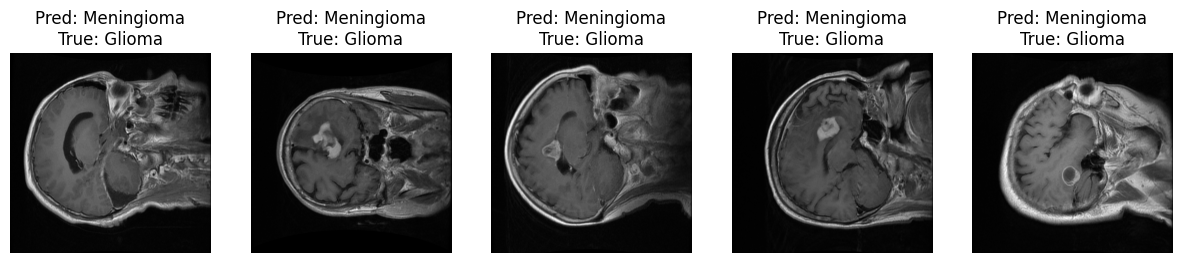

In [32]:
# Konversi y_test dan y_test_pred ke NumPy array jika belum
y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)

# Label numerik untuk masing-masing kelas
label_meningioma = 2  # Sesuai dengan dataset Anda
label_glioma = 1

# Ambil indeks di mana true label adalah Meningioma tetapi diprediksi sebagai Glioma
misclassified_indices = np.where((y_test == label_meningioma) & (y_test_pred == label_glioma))[0]

# Ambil beberapa contoh gambar yang salah diklasifikasikan
num_samples = min(5, len(misclassified_indices))  # Ambil hingga 5 contoh jika ada
misclassified_samples = [test_data[i] for i in misclassified_indices[:num_samples]]

# Visualisasikan hasil
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, sample in enumerate(misclassified_samples):
    axes[i].imshow(sample['image'], cmap='gray')
    axes[i].set_title(f"Pred: Meningioma\nTrue: Glioma")
    axes[i].axis('off')

plt.show()

## **Stacking**

In [33]:
# Tentukan meta-learner terbaik berdasarkan validasi sebelumnya
meta_learner = None
meta_learner_name = None
meta_learner_acc = 0

if best_score_linear >= best_score_poly and best_score_linear >= best_score_rbf:
    meta_learner = best_svm_linear  # Pastikan sudah fit ulang
    meta_learner_name = "Linear SVM"
    meta_learner_acc = best_score_linear
elif best_score_poly >= best_score_linear and best_score_poly >= best_score_rbf:
    meta_learner = best_svm_poly
    meta_learner_name = "Polynomial SVM"
    meta_learner_acc = best_score_poly
else:
    meta_learner = best_svm_rbf
    meta_learner_name = "RBF SVM"
    meta_learner_acc = best_score_rbf

print(f"\nBest Meta Learner: {meta_learner_name} with Acc: {meta_learner_acc:.4f}")


Best Meta Learner: RBF SVM with Acc: 0.9430


In [34]:
# Definisikan ulang base models (pakai model terbaik dari grid search)
base_models = [
    ('svm_linear', best_svm_linear),
    ('svm_poly', best_svm_poly),
    ('svm_rbf', best_svm_rbf)
]

# Gunakan meta-learner terbaik
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_learner, n_jobs=-1)

# Train ulang model stacking
start_train_stacking = time.time()
stacking_clf.fit(X_train_full, y_train_full)
end_train_stacking = time.time()

train_time_stacking_total = end_train_stacking - start_train_stacking
train_time_stacking_per_image = train_time_stacking_total / len(X_train_full)

print(f"Train Time (Stacking): {train_time_stacking_total:.6f} seconds")
print(f"Train Time per Image (Stacking): {train_time_stacking_per_image:.6f} seconds")

Train Time (Stacking): 300.661452 seconds
Train Time per Image (Stacking): 0.085977 seconds


### Confusion Matrix - Training


Training Accuracy: 0.9997
Training Precision: 0.9997
Training Recall: 0.9997
Training F1 Score: 0.9997


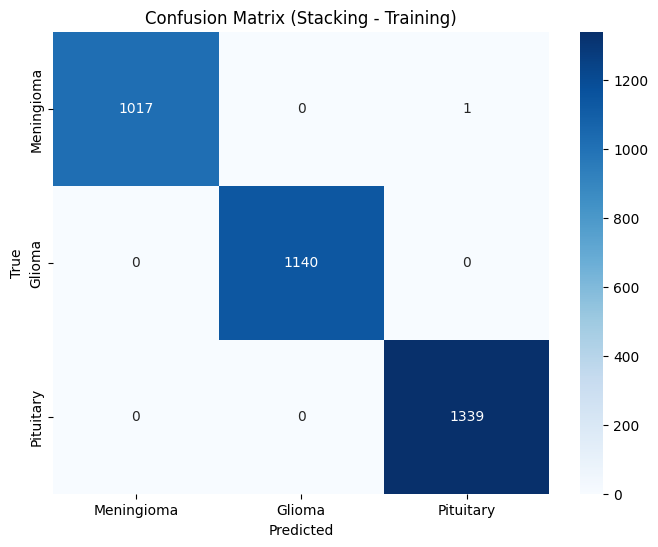

In [35]:
# Prediksi dan evaluasi pada data validasi
y_train_pred = stacking_clf.predict(X_train_full)

train_acc = accuracy_score(y_train_full, y_train_pred)
train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(y_train_full, y_train_pred, average='weighted')

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")

conf_matrix_train = confusion_matrix(y_train_full, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Meningioma', 'Glioma', 'Pituitary'],
            yticklabels=['Meningioma', 'Glioma', 'Pituitary'])
plt.title('Confusion Matrix (Stacking - Training)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Confusion Matrix - Testing


Test Accuracy: 0.9642
Test Precision: 0.9655
Test Recall: 0.9642
Test F1 Score: 0.9644


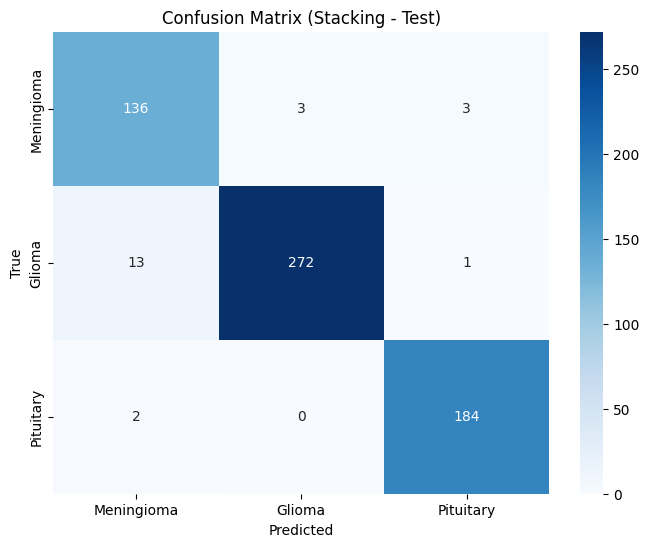

Test Time (Stacking): 5.203703 seconds
Test Time per Image (Stacking): 0.008475 seconds


In [36]:
# Evaluasi pada data uji
start_test_stacking = time.time()
y_test_pred = stacking_clf.predict(X_test)
end_test_stacking = time.time()

test_acc = accuracy_score(y_test, y_test_pred)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Meningioma', 'Glioma', 'Pituitary'],
            yticklabels=['Meningioma', 'Glioma', 'Pituitary'])
plt.title('Confusion Matrix (Stacking - Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

test_time_total = end_test_stacking - start_test_stacking
test_time_per_image = test_time_total / len(X_test)
print(f"Test Time (Stacking): {test_time_total:.6f} seconds")
print(f"Test Time per Image (Stacking): {test_time_per_image:.6f} seconds")

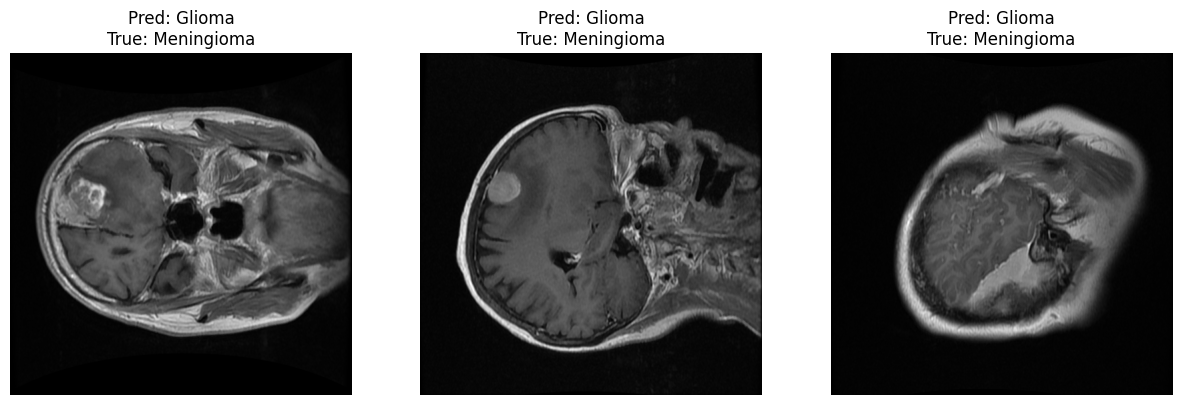

In [39]:
# Konversi y_test dan y_test_pred ke NumPy array jika belum
y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)

# Label numerik untuk masing-masing kelas
label_meningioma = 1  # Sesuai dengan dataset Anda
label_glioma = 2

# Ambil indeks di mana true label adalah Meningioma tetapi diprediksi sebagai Glioma
misclassified_indices = np.where((y_test == label_meningioma) & (y_test_pred == label_glioma))[0]

# Ambil beberapa contoh gambar yang salah diklasifikasikan
num_samples = min(5, len(misclassified_indices))  # Ambil hingga 5 contoh jika ada
misclassified_samples = [test_data[i] for i in misclassified_indices[:num_samples]]

# Visualisasikan hasil
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, sample in enumerate(misclassified_samples):
    axes[i].imshow(sample['image'], cmap='gray')
    axes[i].set_title(f"Pred: Glioma\nTrue: Meningioma")
    axes[i].axis('off')

plt.show()

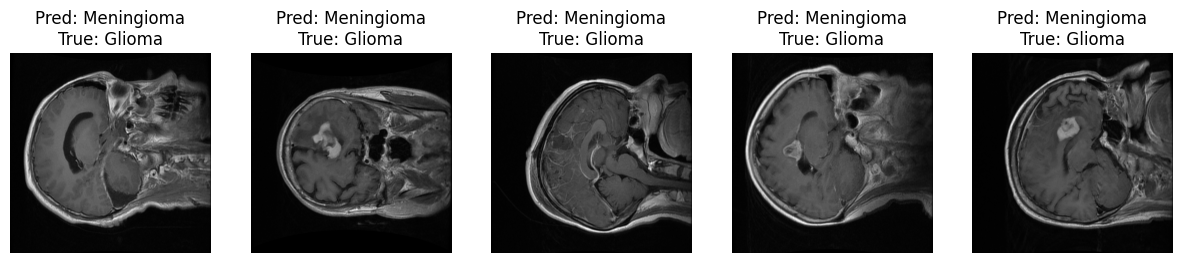

In [38]:
# Konversi y_test dan y_test_pred ke NumPy array jika belum
y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)

# Label numerik untuk masing-masing kelas
label_meningioma = 2  # Sesuai dengan dataset Anda
label_glioma = 1

# Ambil indeks di mana true label adalah Meningioma tetapi diprediksi sebagai Glioma
misclassified_indices = np.where((y_test == label_meningioma) & (y_test_pred == label_glioma))[0]

# Ambil beberapa contoh gambar yang salah diklasifikasikan
num_samples = min(5, len(misclassified_indices))  # Ambil hingga 5 contoh jika ada
misclassified_samples = [test_data[i] for i in misclassified_indices[:num_samples]]

# Visualisasikan hasil
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, sample in enumerate(misclassified_samples):
    axes[i].imshow(sample['image'], cmap='gray')
    axes[i].set_title(f"Pred: Meningioma\nTrue: Glioma")
    axes[i].axis('off')

plt.show()